From the "Supersolid symmetry breaking from compressional oscillations in a dipolar quantum gas" paper (link here [https://arxiv.org/abs/1906.02791](https://arxiv.org/abs/1906.02791)), the authors say:

"The equilibrium density configuration is found by fixing the equation parameters to the values available in the experiments, and then evolving the eGPE in imaginary time. We consider $\mathrm{N}=35000$ atoms of ${ }^{162} \mathrm{Dy}$, for which $a_{d d}=130 a_0\left(a_0\right.$ is the Bohr radius). The trapping frequencies are $\omega_{x, y, z}=2 \pi(18.5,53,81) \mathrm{Hz}$, and $a_s$ is changed to tune the value of $\epsilon_{d d}$."



# import modules

In [2]:
import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import sys
sys.path.append('../../../../../3D-egpe-code/egpe')
from egpe import eGPE


In [3]:


# Define the parameters
nparticles = 35_000
fx, fy, fz = 18.5, 53, 81
# Harmonic oscillator length is given by a_ho = sqrt(hbar/(m*omega)), where m is the mass of the atom, and omega is the 2*pi*f0, where f0 is the frequency of the trap.
# We want to calculate a_h0 / r_0 = sqrt(hbar/(m*omega)/r_0, where r_0 = 390 a_0.
# a_h0/r_0 = sqrt(1.05457182e-34 m^2 kg / s / ( 162 * (1.66053907e-27 kilograms) * (2*pi*20 Hertz)) / (390 * 5.291772109E-11 m)= 1.7662456 microns / ((390 * 5.291772109E-11 m)) = 85.5825757
# a_h0_y = a_h0 * sqrt(18.5/53) = = 85.5825757 * sqrt(18.5/53) = 50.563052245
# a_h0_z = a_h0 * sqrt(18.5/81) = = 85.5825757 * sqrt(18.5/81) = 40.9005085201



# Get the optimal sr and sz
gp = eGPE(eps_dd=1.38,
          nparticles=nparticles,
          fx=fx, fy=fy, fz=fz,
          nxyz=np.array([256, 64, 32]) / 2,
          box_size=np.array([90, 50, 41]) * np.array([0.9, 0.75, 1]) * 50 / 2,
          )

r0 = gp.box_size / 20
gp.psi = np.exp(-0.5 * (gp.x / r0[0])**2 - 0.5 * (gp.y / r0[1])**2 - 0.5 * (gp.z / r0[2])**2) + 0j
gp.psi *= np.random.normal(0.9, 1, gp.psi.shape)
gp.normalize_psi()


[INFO] Initializing random psi


In [4]:
gp.a_s * gp.r_0

94.20289855072464

In [14]:
dt = 10
t_max = dt * 10000
gp.evolve(dt=dt, t_max=t_max, verbose=False, output_root_dir="./")

[INFO] Created output directory:  .//snapshots_time_evolution_0


100%|██████████| 10000/10000 [02:16<00:00, 73.27it/s]


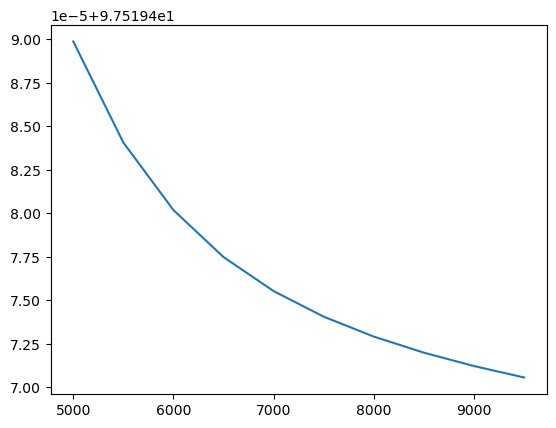

In [38]:
path = "./snapshots_time_evolution_0"
# loadtxt from energy.txt in path
energy = np.loadtxt(f"{path}/energy.txt")
# energy contains: step, en, kin_en, pot_ext pot_int
step = energy[:,0]
en = energy[:,1]

# ignore first IGNORE_FIRST steps
IGNORE_FIRST = 10
step = step[IGNORE_FIRST:]
en = en[IGNORE_FIRST:]

# Plot each energy component, each in its figure
plt.plot(step, en, label="Total energy")

OK, now the system is equilibrated. Let's change $\lambda$ from 10^-6 to 10^-2 (in logarithmic scale) and see what happens with the <x^2>

In [35]:



# Prepare lambda values
lambda_values = np.logspace(-3, 0, 9)
avg_x2_values = []

for lambda_ext in lambda_values:
    
    
    # Set the external potential
    gp.lambda_pot_external = lambda_ext
    gp.set_external_potential()
    
    r0 = gp.box_size / 20
    gp.psi = np.exp(-0.5 * (gp.x / r0[0])**2 - 0.5 * (gp.y / r0[1])**2 - 0.5 * (gp.z / r0[2])**2) + 0j
    gp.psi *= np.random.normal(0.9, 1, gp.psi.shape)
    gp.normalize_psi()

    # Print some info
    print(f"lambda_ext = {lambda_ext}")

    # Evolve the system
    dt = 10
    t_max = dt * 100000
    gp.evolve(dt=dt, t_max=t_max, verbose=False)

    # save the average x^2
    avg_x2 = np.sum(gp.x**2 * gp.den) / np.sum(gp.den)
    avg_x2_values.append(avg_x2)


lambda_ext = 0.001


100%|██████████| 100000/100000 [23:13<00:00, 71.75it/s]


lambda_ext = 0.0023713737056616554


100%|██████████| 100000/100000 [22:44<00:00, 73.27it/s]


lambda_ext = 0.005623413251903491


100%|██████████| 100000/100000 [22:41<00:00, 73.46it/s]


lambda_ext = 0.01333521432163324


100%|██████████| 100000/100000 [22:40<00:00, 73.48it/s]


lambda_ext = 0.03162277660168379


100%|██████████| 100000/100000 [22:36<00:00, 73.71it/s]


lambda_ext = 0.07498942093324558


100%|██████████| 100000/100000 [22:45<00:00, 73.23it/s]


lambda_ext = 0.1778279410038923


100%|██████████| 100000/100000 [22:49<00:00, 73.03it/s]


lambda_ext = 0.4216965034285822


100%|██████████| 100000/100000 [22:37<00:00, 73.66it/s]


lambda_ext = 1.0


100%|██████████| 100000/100000 [22:33<00:00, 73.90it/s]


In [36]:
# Save lambda_values and avg_x2_values as files in folder ./data_results
# Create the folder if it does not exist
import os
if not os.path.exists("./data_results"):
    os.makedirs("./data_results")

np.savetxt("./data_results/lambda_values.txt", lambda_values)
np.savetxt("./data_results/avg_x2_values.txt", avg_x2_values)

In [41]:
# Load the data from data_result
lambda_values = np.loadtxt("./data_results/lambda_values.txt")
avg_x2_values = np.loadtxt("./data_results/avg_x2_values.txt")

# Analyze the data

In [42]:
# copy the data
lambda_values_og = lambda_values.copy()
avg_x2_values_og = avg_x2_values.copy()

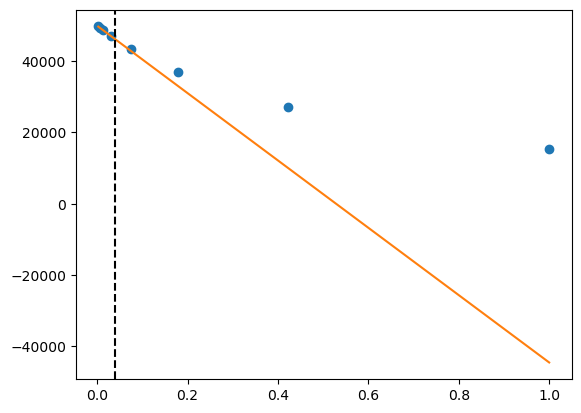

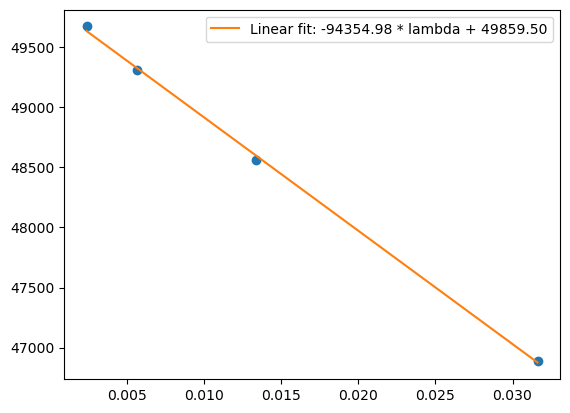

In [44]:

lambda_values = np.array(lambda_values_og)
avg_x2_values = np.array(avg_x2_values_og)

# take values smaller than 10
mask = lambda_values > 1.E-3
lambda_values = lambda_values[mask]
avg_x2_values = avg_x2_values[mask]

# plot the average x^2
plt.figure()
plt.plot(lambda_values, avg_x2_values, marker="o", ls='')
# fit a linear function to the data. Don't use log scale for lambda, because it's not linear
LAMBDA_VAL_THRESHOLD = 0.04
mask = lambda_values < LAMBDA_VAL_THRESHOLD
fit = np.polyfit(lambda_values[mask], avg_x2_values[mask], deg=1)
plt.plot(lambda_values, fit[0] * lambda_values + fit[1], label=f"Linear fit: {fit[0]:.2f} * lambda + {fit[1]:.2f}")

# plot vertical line at LAMBDA_VAL_THRESHOLD
plt.axvline(LAMBDA_VAL_THRESHOLD, ls="--", color="k")

# add a new plot focuses on the region with lambda < LAMBDA_VAL_THRESHOLD
mask = lambda_values < LAMBDA_VAL_THRESHOLD
plt.figure()
plt.plot(lambda_values[mask], avg_x2_values[mask], marker="o", ls='')
plt.plot(lambda_values[mask], fit[0] * lambda_values[mask] + fit[1], label=f"Linear fit: {fit[0]:.2f} * lambda + {fit[1]:.2f}")
    


plt.legend()